In [10]:
#Librerias
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [11]:
# Define the stock symbol and period
stock_symbol = "COST"  # Costco's stock symbol
start_date = "2014-11-01"
end_date = "2024-11-01"

# Download historical data for the past 10 years with daily frequency
costco_data = yf.download(stock_symbol, start=start_date, end=end_date, interval="1d")

# Display the first few rows of the data to check
print(costco_data.head())


[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close  Adj Close   Volume
Date                                                                          
2013-11-01  118.709999  119.800003  118.550003  119.620003  95.703468  2185100
2013-11-04  120.000000  120.400002  119.260002  120.339996  96.279495  1588900
2013-11-05  120.150002  120.430000  119.099998  120.129997  96.111481  1419700
2013-11-06  120.440002  124.559998  120.320000  124.070000  99.263695  3059000
2013-11-07  124.739998  124.739998  122.510002  122.779999  98.231651  2459500


In [12]:
# Extraemos solo los precios de cierre
close_prices = costco_data[['Close']].values

# Normalizamos los datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_normalized = scaler.fit_transform(close_prices)

# Definimos la longitud de la secuencia (ej. 60 días)
sequence_length = 60 #252 dias
X_train = []
y_train = []

# Creamos secuencias de 60 días de datos
for i in range(sequence_length, len(close_prices_normalized)):
    X_train.append(close_prices_normalized[i-sequence_length:i, 0])
    y_train.append(close_prices_normalized[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Redimensionamos X_train para añadir la dimensión de características (necesaria para las RNN/LSTM)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [13]:
# Configuración del generador
def build_generator():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=1, activation='tanh'))
    return model

# Configuración del discriminador
def build_discriminator():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=1, activation='sigmoid'))
    return model


In [14]:

# Crear instancias del generador y discriminador
generator = build_generator()
discriminator = build_discriminator()

# Compilar el discriminador
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Definir la GAN combinada
discriminator.trainable = False  # Congelar los pesos del discriminador durante el entrenamiento de la GAN
gan_input = tf.keras.Input(shape=(sequence_length, 1))
generated_sequence = generator(gan_input)
gan_output = discriminator(generated_sequence)
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5)) #funcion que teniamos

# Parámetros de entrenamiento
epochs = 100 #Menos para que no sea tan pesado eran 1000
batch_size = 32

# Etiquetas para datos reales y generados
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

# Entrenamiento de la GAN
for epoch in range(epochs):
    # Seleccionar un conjunto aleatorio de secuencias reales
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_sequences = X_train[idx]

    # Generar secuencias sintéticas
    noise = np.random.normal(0, 1, (batch_size, sequence_length, 1))
    generated_sequences = generator.predict(noise)

    # Entrenar el discriminador (reales como 1 y generadas como 0)
    d_loss_real = discriminator.train_on_batch(real_sequences, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_sequences, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Entrenar el generador (objetivo: que el discriminador clasifique las secuencias generadas como reales)
    g_loss = gan.train_on_batch(noise, real_labels)

    # Imprimir el progreso
    if epoch % 100 == 0:
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")


C:\Users\ulise\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step


C:\Users\ulise\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.6939288377761841, acc.: 40.625%] [G loss: 0.6931484937667847]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━

In [15]:
# Generar secuencias de precios sintéticas
n_scenarios = 10 #Eran 100 pero lo disminuyo para que sea mas facil
generated_scenarios = []

for _ in range(n_scenarios):
    noise = np.random.normal(0, 1, (1, sequence_length, 1))
    generated_sequence = generator.predict(noise)
    generated_scenarios.append(generated_sequence)

# Convertir a un arreglo numpy y deshacer la normalización para tener valores reales
generated_scenarios = np.array(generated_scenarios).reshape(n_scenarios, sequence_length)
generated_scenarios = scaler.inverse_transform(generated_scenarios)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━

ValueError: cannot reshape array of size 100 into shape (100,60)

In [32]:

# Función para calcular las Bandas de Bollinger
def calculate_bollinger_bands(data, window=20):
    data['MA20'] = data['Close'].rolling(window).mean()
    data['stddev'] = data['Close'].rolling(window).std()
    data['Upper'] = data['MA20'] + (data['stddev'] * 2)
    data['Lower'] = data['MA20'] - (data['stddev'] * 2)
    return data

# Aplicar Bandas de Bollinger a los datos reales
costco_data = calculate_bollinger_bands(costco_data)

# Parámetros de la estrategia
stop_loss = 0.05  # 5%
take_profit = 0.10  # 10%

# Función mejorada de backtesting con registro de valor de portafolio diario
def backtest_strategy(data):
    positions = []  # Almacenar operaciones
    position_open = False  # Indicar si estamos en una operación
    entry_price = 0  # Precio de entrada
    cash = 10000  # Dinero inicial
    shares = 0  # Acciones en posesión
    cash_values = [cash]  # Almacenar el valor de portafolio diario

    for i in range(len(data)):
        price = data['Close'].iloc[i]

        # Señal de compra (cruce por debajo de la banda inferior)
        if not position_open and price < data['Lower'].iloc[i]:
            position_open = True
            entry_price = price
            shares = cash / entry_price
            positions.append({'Type': 'Buy', 'Price': entry_price, 'Date': data.index[i]})

        # Señal de venta (cruce por encima de la banda superior o condiciones de take-profit / stop-loss)
        elif position_open:
            if (price >= entry_price * (1 + take_profit)) or (price <= entry_price * (1 - stop_loss)) or (price > data['Upper'].iloc[i]):
                position_open = False
                cash = shares * price
                positions.append({'Type': 'Sell', 'Price': price, 'Date': data.index[i]})
                shares = 0

        # Almacenar el valor de portafolio diario, tanto si estamos en posición como si no
        portfolio_value = cash if not position_open else shares * price
        cash_values.append(portfolio_value)

    return positions, cash_values  # Devolver las operaciones y el valor del portafolio diario

# Backtesting en los datos reales de Costco
positions, cash_values = backtest_strategy(costco_data)

# Mostrar los resultados del backtest en datos reales
print(f"Final Portfolio Value: ${cash_values[-1]:.2f}")
print("Trade List:")
for pos in positions:
    print(pos)


Final Portfolio Value: $15881.45
Trade List:
{'Type': 'Buy', 'Price': 120.94999694824219, 'Date': Timestamp('2013-12-05 00:00:00')}
{'Type': 'Sell', 'Price': 114.05000305175781, 'Date': Timestamp('2014-01-08 00:00:00')}
{'Type': 'Buy', 'Price': 114.7699966430664, 'Date': Timestamp('2014-01-13 00:00:00')}
{'Type': 'Sell', 'Price': 114.79000091552734, 'Date': Timestamp('2014-04-23 00:00:00')}
{'Type': 'Buy', 'Price': 122.94999694824219, 'Date': Timestamp('2014-10-16 00:00:00')}
{'Type': 'Sell', 'Price': 130.27999877929688, 'Date': Timestamp('2014-10-21 00:00:00')}
{'Type': 'Buy', 'Price': 147.11000061035156, 'Date': Timestamp('2015-04-16 00:00:00')}
{'Type': 'Sell', 'Price': 138.77999877929688, 'Date': Timestamp('2015-06-05 00:00:00')}
{'Type': 'Buy', 'Price': 138.0500030517578, 'Date': Timestamp('2015-06-08 00:00:00')}
{'Type': 'Sell', 'Price': 142.72000122070312, 'Date': Timestamp('2015-07-10 00:00:00')}
{'Type': 'Buy', 'Price': 143.7100067138672, 'Date': Timestamp('2015-08-20 00:00:00

In [33]:
# Almacenar los resultados de backtesting en escenarios generados
synthetic_results = []

for scenario in generated_scenarios:
    # Convertir cada escenario en un DataFrame temporal para calcular las Bandas de Bollinger
    temp_df = pd.DataFrame(scenario, columns=['Close'])
    temp_df = calculate_bollinger_bands(temp_df)

    # Realizar el backtesting en el escenario generado
    positions, final_cash = backtest_strategy(temp_df)
    synthetic_results.append(final_cash)


In [34]:
# Estrategia pasiva con almacenamiento diario del valor de portafolio
def passive_strategy(data):
    cash = 10000  # Dinero inicial
    buy_price = data['Close'].iloc[0]
    shares = cash / buy_price
    cash_values = [shares * price for price in data['Close']]  # Guardar el valor del portafolio diariamente
    return cash_values

# Calcular el valor del portafolio diario para la estrategia pasiva
cash_values_passive = passive_strategy(costco_data)

# Calcular métricas en base al valor diario del portafolio
metrics_passive = calculate_metrics(cash_values_passive)

# Resultados finales
print("Metrics for Active Strategy (Real Data):", metrics_real)
print("Metrics for Passive Strategy:", metrics_passive)


Metrics for Active Strategy (Real Data): (0.4092747546407547, -0.4825862265564125, 5881.4476057539305, 0.18679245283018867)
Metrics for Passive Strategy: (0.8304141677004423, -0.818797792094208, 36182.91170012462, 1.1550985432733505)


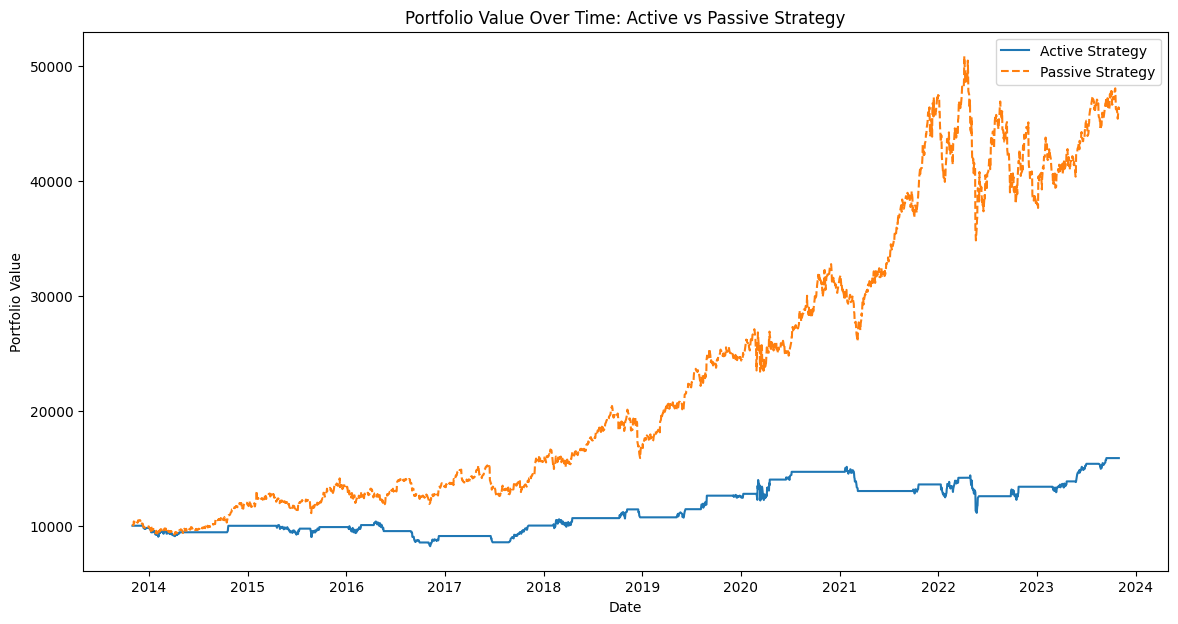

In [38]:
# Asegurar que cash_values tenga la misma longitud que costco_data.index
# Si cash_values es más largo, tomamos solo los valores que coincidan con costco_data.index
cash_values = cash_values[:len(costco_data.index)]
cash_values_passive = cash_values_passive[:len(costco_data.index)]

# Gráfico de valor del portafolio en el tiempo para ambas estrategias
plt.figure(figsize=(14, 7))
plt.plot(costco_data.index, cash_values, label="Active Strategy")
plt.plot(costco_data.index, cash_values_passive, label="Passive Strategy", linestyle="--")
plt.title("Portfolio Value Over Time: Active vs Passive Strategy")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()
